In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
from data_loaders import DataBlob
from utils import featurize, update_vars
import scanpy as sc
from modules.vae import SpatialVAE
from torch import optim
from modules.losses import Lossv2
from early_stopping import EarlyStopping
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torch
from utils import clr_normalize_each_cell
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import scale
from scipy.stats import spearmanr
import umap.umap_ as umap
import squidpy as sq
import math
from leiden_clustering import LeidenClustering
from anndata import AnnData
warnings.filterwarnings('ignore')

In [13]:
import pandas as pd
from sklearn.decomposition import PCA

In [3]:
def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [4]:
dataset = DataBlob()

Injesting Data...: 100%|██████████| 4/4 [00:24<00:00,  6.01s/it]


In [177]:
spleen1, spleen2 = dataset.load_data()

In [178]:
tissue = 'Tonsil'
adata = sc.read_visium(path=f'/ix/hosmanbeyoglu/kor11/CytAssist/{tissue}/GEX_PEX')
adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)
adt_ref = pd.read_csv('/ix/hosmanbeyoglu/kor11/CytAssist/Brain/GEX_PEX/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_feature_reference.csv')
pdata = adata[:, [i in adt_ref[adt_ref.isotype_control==False].id.values for i in adata.var_names]]
adata = adata[:, [i not in adt_ref[adt_ref.isotype_control==False].id.values and 'MT-' not in i for i in adata.var_names]]
pdata.var.feature_types = 'Antibody Capture'

Trying to set attribute `.var` of view, copying.


In [130]:
# adata2 = sc.read_visium(path=f'/ix/hosmanbeyoglu/kor11/CytAssist/{tissue}/GEX')
# adata2.obsm['spatial'] = adata2.obsm['spatial'].astype(float)
# common = set(np.intersect1d(adata.var_names, adata2.var_names))
# adata2 = adata2[:, [i in common for i in adata2.var_names]]
# adata = adata[:, [i in common for i in adata.var_names]]

In [158]:
# datapath = Path('/ix/hosmanbeyoglu/kor11/SpaceCovid')
# protein_tsv = 'GSM6578071_humantonsil_protein.tsv'
# rna_tsv = 'GSM6578062_humantonsil_RNA.tsv'

# rna = pd.read_csv(datapath/rna_tsv, sep='\t', engine="pyarrow")
# protein = pd.read_csv(datapath/protein_tsv, sep='\t', engine="pyarrow")
# protein = protein.set_index('X').drop('unmapped', axis=1).loc[rna.X]
# # protein.columns = list(map(lambda x: antibody_map[x], protein.columns))
# protein = AnnData(protein)
# protein.X = csr_matrix(protein.X)
# rna = AnnData(rna.set_index('X'))
# rna.uns['protein'] = protein
# adata = rna
# xy = np.array([(a, b) for a, b in pd.Series(rna.obs.index).str.split('x').apply(
#     lambda x: (int(x[0]), int(x[1]))).values])
# adata.obsm['spatial'] = xy
# rna.uns['protein'].obsm['spatial'] = xy
# adata.X = csr_matrix(adata.X)
# adata.layers['counts'] = adata.X

# adata.uns['spatial'] = {}
# adata.uns['spatial'][rna_tsv] = {}
# adata.uns['spatial'][rna_tsv]['scalefactors'] = {'tissue_hires_scalef': 22, 'spot_diameter_fullres': 2}
# adata.uns['spatial'][rna_tsv]['images'] = {}
# adata.uns['spatial'][rna_tsv]['images']['hires'] = plt.imread(f'{str(datapath)}/tonsil.jpg')

In [5]:
def reduce(data, labels):
    datax = []
    n_neighbors = None
    for i, (dat, lab) in enumerate(zip(data, labels)):
        if i == 0 or separate_dim:
            red = cuml.UMAP(
                n_components=2,
                n_neighbors=min(200, dat.shape[0] - 1) if n_neighbors is None else n_neighbors,
                min_dist=.5,
                random_state=42)

            red.fit(np.concatenate(data, axis=0))
        plot_data = red.transform(dat)
        datax.append(plot_data)

In [74]:
import cuml

def plot_latent(
    data,
    labels,
    names=None,
    legend=False,
    remove_outliers=False,
    n_components=2,
    separate_dim=False,
    square=False,
    method='umap',
    n_neighbors=None,
    seed=42,
    reduce_only=False
):
    method_names = {'pca': 'PC', 'umap': 'UMAP'}
    axs = []
    datax = []
    
    plt.rcParams['figure.figsize'] = (16, 8)

    for i, (dat, lab) in enumerate(zip(data, labels)):
        ax = plt.gcf().add_subplot(1, len(data), i+1, projection=None)
        axs.append(ax)
        if i == 0 or separate_dim:
            red = cuml.UMAP(
                n_components=n_components,
                n_neighbors=min(200, dat.shape[0] - 1) if n_neighbors is None else n_neighbors,
                min_dist=.5,
                random_state=seed)
            if separate_dim:
                red.fit(dat)
            else:
                red.fit(np.concatenate(data, axis=0))
        plot_data = red.transform(dat)
        datax.append(plot_data)
        
        if remove_outliers:
            filter = outliers(plot_data)
        for l in np.unique(np.concatenate(labels)):
            data_subset = np.transpose(plot_data[lab == l])
            if remove_outliers:
                data_subset[~filter[lab == l].T] = np.nan
            # ax.scatter(*data_subset, s=3e3*(1/dat.shape[0]), label=l)
            ax.scatter(*data_subset, s=55, label=l, edgecolors='black')
            
        if i == 1 and legend:
            ax.legend()
        if names is not None:
            ax.set_title(names[i])
        ax.set_xlabel(f'{method_names[method]}-1')
        ax.set_ylabel(f'{method_names[method]}-2')
        if n_components == 2 and square:
            ax.set_aspect('equal')
        elif n_components == 3:
            ax.set_zlabel(f'{method_names[method]}-3')
            if square:
                # https://stackoverflow.com/a/13701747
                X, Y, Z = np.transpose(plot_data)
                # Create cubic bounding box to simulate equal aspect ratio
                max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
                Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
                Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
                Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
                for xb, yb, zb in zip(Xb, Yb, Zb):
                    ax.plot([xb], [yb], [zb], 'w')
                    
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
    if not separate_dim:
        axs_xlim = np.array([ax.get_xlim() for ax in axs])
        axs_ylim = np.array([ax.get_ylim() for ax in axs])
        new_xlim = (axs_xlim.min(axis=0)[0], axs_xlim.max(axis=0)[1])
        new_ylim = (axs_ylim.min(axis=0)[0], axs_ylim.max(axis=0)[1])
        for ax in axs:
            ax.set_xlim(new_xlim)
            ax.set_ylim(new_ylim)
            
    if reduce_only:
        plt.close()
    else:
        plt.show()
    return datax

In [8]:
# adata = dataset[0] 
# sc.pp.filter_genes(adata, min_counts=5)
# sc.pp.filter_cells(adata, min_counts=5)
# pdata = adata.uns['protein']
# pdata.obsm['spatial'] = adata.obsm['spatial']
# pdata.raw = pdata
# pdata.X = pdata.X.astype(float)
# data11 = adata.X.toarray()
# data12 = pdata.X.toarray()

# sc.tl.pca(pdata)
# sc.pp.neighbors(pdata)
# sc.tl.leiden(pdata, resolution=0.3)

# type1 = pdata.obs.leiden.values
# type2 = pdata.obs.leiden.values

In [180]:
# sc.pp.filter_genes(adata, min_counts=5)
# sc.pp.filter_cells(adata, min_counts=5)
# pdata.obsm['spatial'] = adata.obsm['spatial']
# pdata.raw = pdata
# pdata.X = pdata.X.astype(float)
# data11 = adata.X.toarray()
# data12 = pdata.X.toarray()

# sc.tl.pca(pdata)
# sc.pp.neighbors(pdata)
# sc.tl.leiden(pdata, resolution=0.3)

# type1 = pdata.obs.leiden.values
# type2 = pdata.obs.leiden.values

Trying to set attribute `.var` of view, copying.


In [274]:
adata = spleen1.copy()
pdata = adata.uns['protein']

# sc.pp.filter_genes(adata, min_counts=5)
# sc.pp.filter_genes(pdata, min_counts=5)

pdata.obsm['spatial'] = adata.obsm['spatial']
pdata.raw = pdata
pdata.X = pdata.X.astype(float)
data11 = adata.X.toarray()
data12 = pdata.X.toarray()

sc.tl.pca(pdata)
sc.pp.neighbors(pdata)
sc.tl.leiden(pdata, resolution=0.3)

type1 = pdata.obs.leiden.values
type2 = pdata.obs.leiden.values

In [242]:
pdata.obsm['spatial'][:, 0].min(), pdata.obsm['spatial'][:, 0].max(), pdata.obsm['spatial'][:, 1].min(), pdata.obsm['spatial'][:, 1].max()

(661, 2731, 321, 2236)

... storing 'Replicate' as categorical
... storing 'Clustering' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


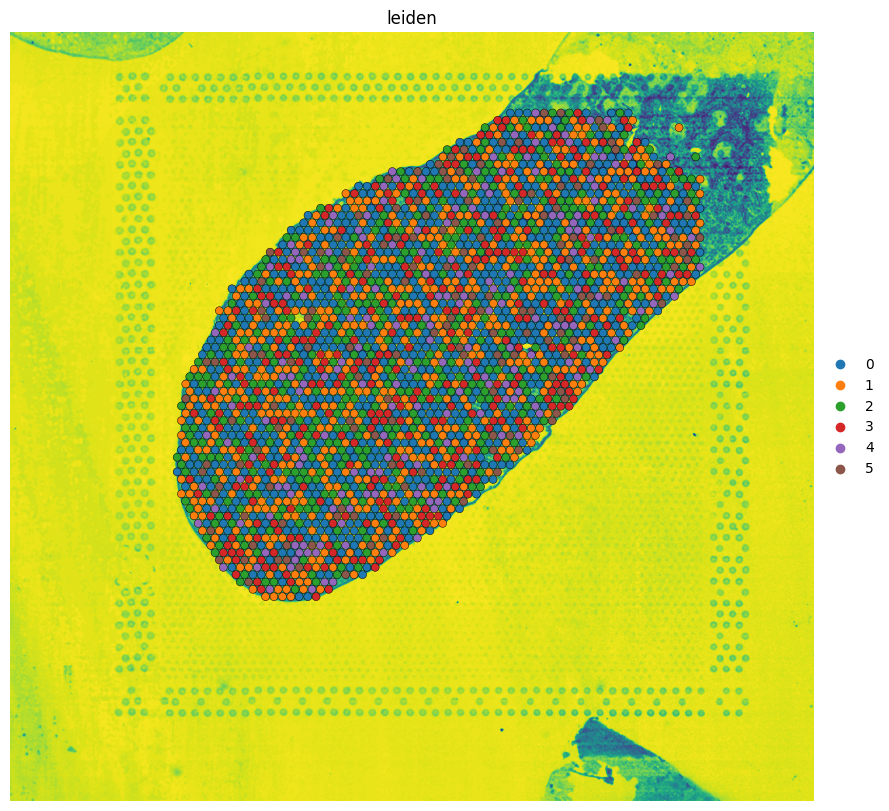

In [243]:
sq.pl.spatial_scatter(pdata, color='leiden', frameon=False, size=1.45, edgecolor='black', linewidth=0.35, crop_coord=tuple([0, 0, 28000, 40000]))

In [290]:
gex = featurize(adata, pca_dim=1024)
pex = featurize(pdata, pca_dim=1024, clr=False)
d11, d12 = gex.features.cpu().numpy(), pex.features.cpu().numpy()
corr = torch.eye(d11.shape[0], d12.shape[0]).cuda()
d11.shape, d12.shape

((2568, 32285), (2568, 21))

In [276]:
adata2 = spleen2.copy()
pdata2 = adata2.uns['protein']
pdata2.obsm['spatial'] = adata2.obsm['spatial']
pdata2.raw = pdata2
pdata2.X = pdata2.X.astype(float)
data112 = adata2.X.toarray()
data122 = pdata2.X.toarray()

sc.tl.pca(pdata2)
sc.pp.neighbors(pdata2)
sc.tl.leiden(pdata2, resolution=0.3)

type12 = pdata2.obs.leiden.values
type22 = pdata2.obs.leiden.values

gex2 = featurize(adata2, pca_dim=1024)
pex2 = featurize(pdata2, pca_dim=1024, clr=False)
d112, d122 = gex2.features.cpu().numpy(), pex2.features.cpu().numpy()
corr2 = torch.eye(d112.shape[0], d122.shape[0]).cuda()
d112.shape, d122.shape

((2751, 32285), (2751, 21))

In [291]:
pca1 = PCA(n_components=21).fit(d11)
pca2 = PCA(n_components=21).fit(d12)
d11_pca = pca1.transform(d11)
d12_pca = pca2.transform(d12)

In [294]:
d112_pca = pca1.transform(d112)
d122_pca = pca2.transform(d122)

In [295]:
d11 = torch.tensor(d11_pca).cuda()
d12 = torch.tensor(d12_pca).cuda()

In [296]:
d112 = torch.tensor(d112_pca).cuda()
d122 = torch.tensor(d122_pca).cuda()

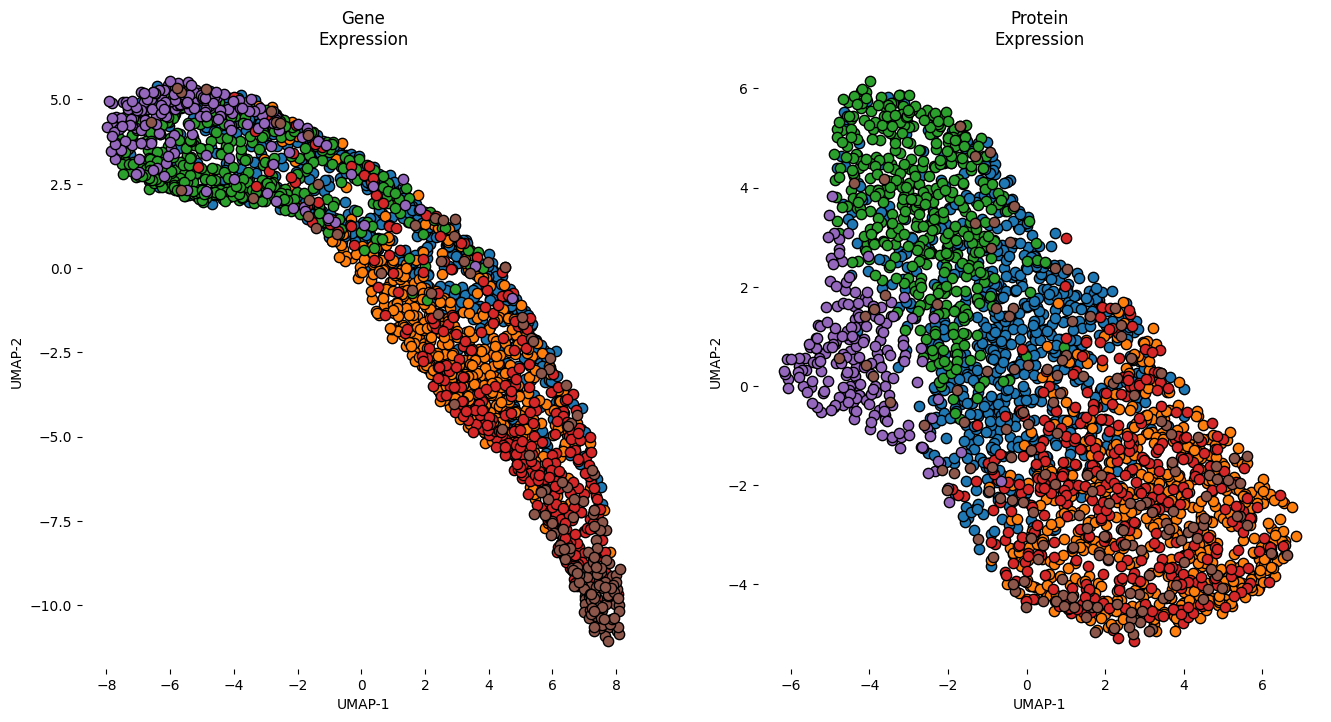

In [297]:
xyp, xyg = plot_latent([d11.cpu().numpy(), d12.cpu().numpy()], [type1, type2], 
            ['Gene\nExpression', 'Protein\nExpression'], 
            legend=False, method='umap',
            separate_dim=True);

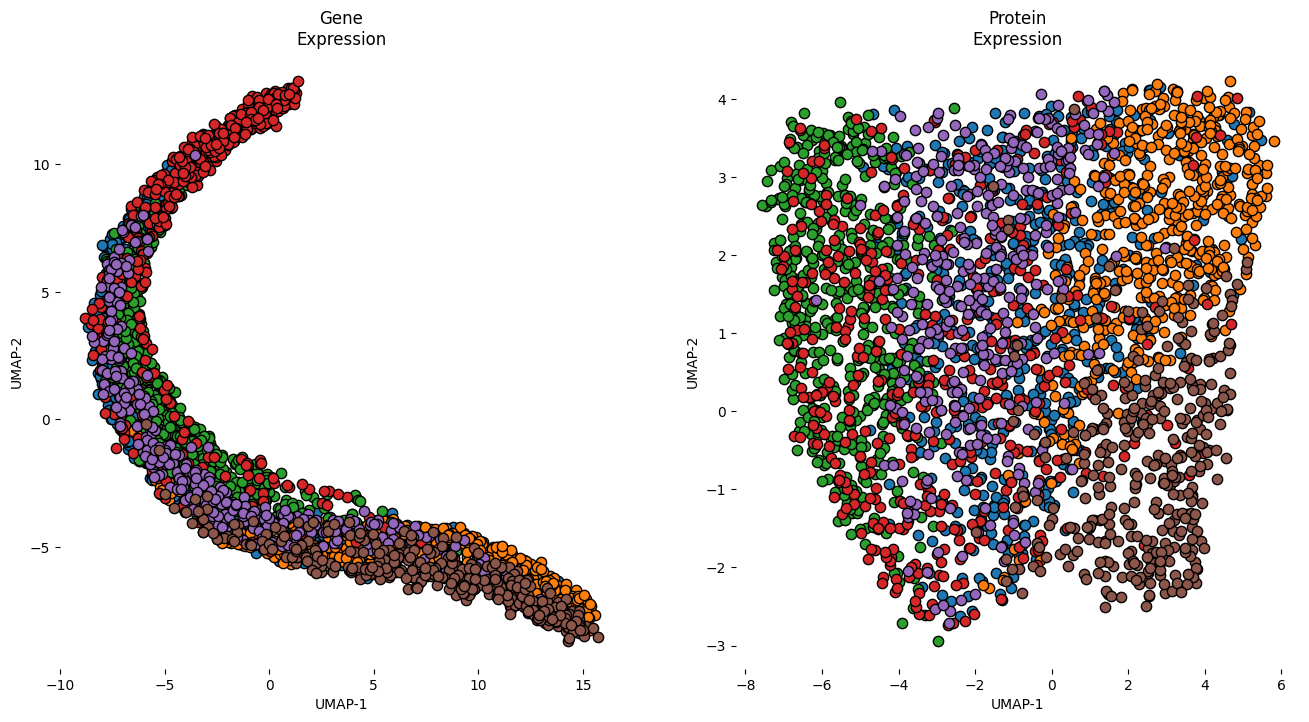

In [298]:
xyp, xyg = plot_latent([d112.cpu().numpy(), d122.cpu().numpy()], [type12, type22], 
            ['Gene\nExpression', 'Protein\nExpression'], 
            legend=False, method='umap',
            separate_dim=True);

In [323]:
model = SpatialVAE([d11.shape[1], d12.shape[1]], 32).cuda()
optimizer = optim.Adam(model.parameters(), lr=2e-3, weight_decay=0)
es = EarlyStopping(patience=1000, verbose=False, delta=1e-3, path='gvae.pth')
loss_func = Lossv2()
loss_func.alpha = {
    'kl_gex': 1e-9,
    'kl_pex': 1e-9,
    'recons_gex': 1,
    'recons_pex': 1e-1,
    'cosine': 1e-2,
    'consistency': 0,
    'adj': 1e-8,
    'spatial': 1e-7,
    'alignment': 1e-3
}

In [324]:
epochs = 50000
losses = []
oracle = []
oracle_x = []
embeds = []
feats = d11.data.cpu().numpy()

with tqdm(total=epochs) as pbar:
    for e in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X=[d11, d12], A=gex.adj_norm, corr=corr)
        output.epochs = epochs
        output.gex_features_pca = d11
        output.adj_label = gex.adj_label
        output.pos_weight = gex.pos_weight
        output.gex_sp_dist = gex.sp_dists
        output.corr = gex.adj_label
        
        output.norm = gex.norm
        
        output.pex_features_pca = d12
        loss = loss_func.compute(e, output)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        losses.append(float(loss))
        
        es(-1*np.mean(oracle), model)   
        # if es.early_stop: 
        #     model = es.best_model
        #     break
        
        if e == 0 or e % 100 == 0:
            a = output.gex_recons.data.cpu().numpy()
            cor_mean = np.mean([spearmanr(feats[:, ixs], a[:, ixs]).statistic for ixs in range(a.shape[1])])
        
        model.eval()
            
        proteins = model.decoders[1](model.fc_mus[0](model.encoders[0](d11, gex.adj_norm), gex.adj_norm))
        corrsx = []
        c = proteins.detach().cpu().numpy()
        d = d12.cpu().numpy()

        for ixs in range(d.shape[1]):
            corrsx.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)   
        
        oracle.append(np.mean(corrsx))
            
        proteins = model.decoders[1](model.fc_mus[0](model.encoders[0](d112, gex2.adj_norm), gex2.adj_norm))
        corrsx = []
        c = proteins.detach().cpu().numpy()
        d = d122.cpu().numpy()

        for ixs in range(d.shape[1]):
            corrsx.append(spearmanr(d[:, ixs], c[:, ixs]).statistic) 

        oracle_x.append(np.mean(corrsx))
            
            
        pbar.update()

        pbar.set_description(f'Oracle_X: {np.mean(oracle_x):.3f} | Oracle: {np.mean(oracle):.3f} | Corr: {cor_mean:.3f} | Loss: {np.mean(losses):.3e} | Align: {loss_func.mean_align:.3e} | Cosine: {loss_func.mean_cosine:.3e} \
| Spatial: {loss_func.mean_spatial:.3e} | Adj: {loss_func.mean_adj:.3e} | MSE_Gex: {loss_func.mean_recons_gex:.3e} | MSE_Pex: {loss_func.mean_recons_pex:.3e}')

Oracle_X: 0.021 | Oracle: 0.099 | Corr: 0.278 | Loss: 8.893e-02 | Align: 1.065e-03 | Cosine: 1.003e-02 | Spatial: 6.205e-05 | Adj: 5.155e-08 | MSE_Gex: 7.798e-02 | MSE_Pex: 8.460e-04: 100%|██████████| 50000/50000 [1:16:49<00:00, 10.85it/s]


In [327]:
model.eval()
integrated_data =  model(X=[d11, d12], A=gex.adj_norm, corr=corr)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

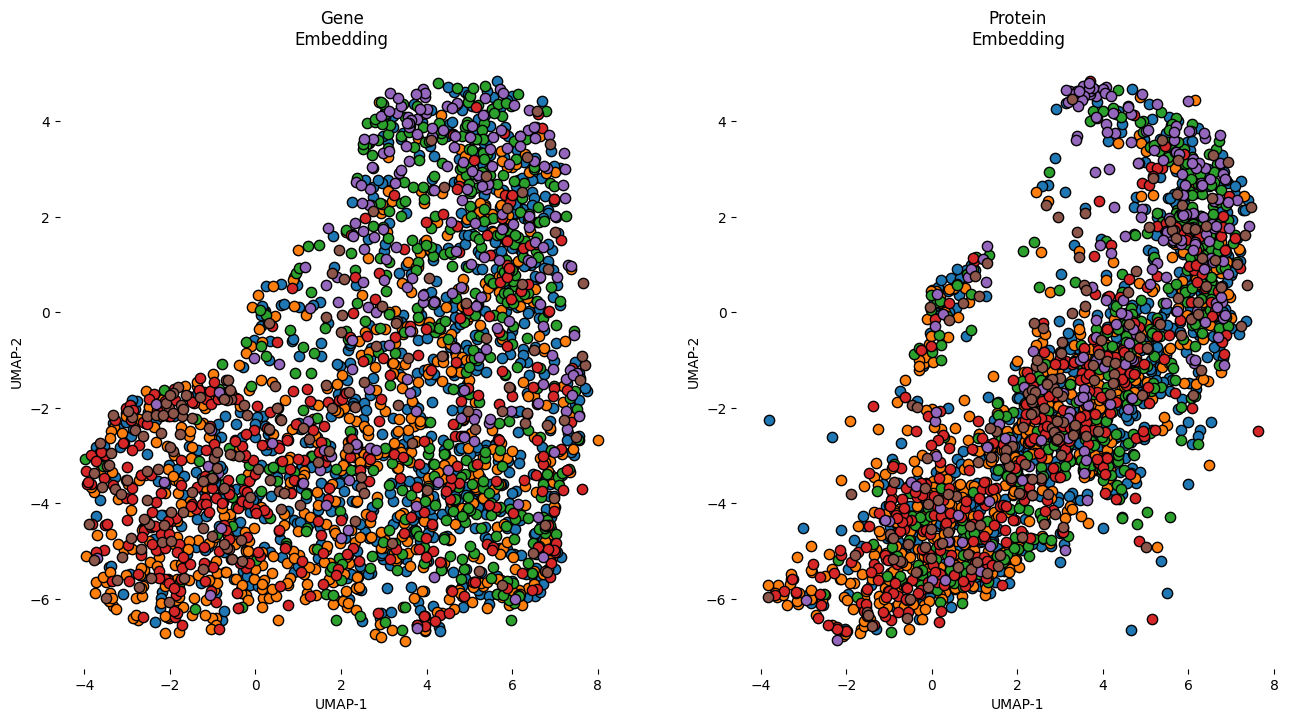

In [328]:
a, b = plot_latent([gex_z, pex_z], [type1, type2], 
            ['Gene\nEmbedding', 'Protein\nEmbedding'], 
            legend=False, method='umap',
            separate_dim=False);

In [329]:
model.eval()
integrated_data =  model(X=[d112, d122], A=gex2.adj_norm, corr=corr2)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

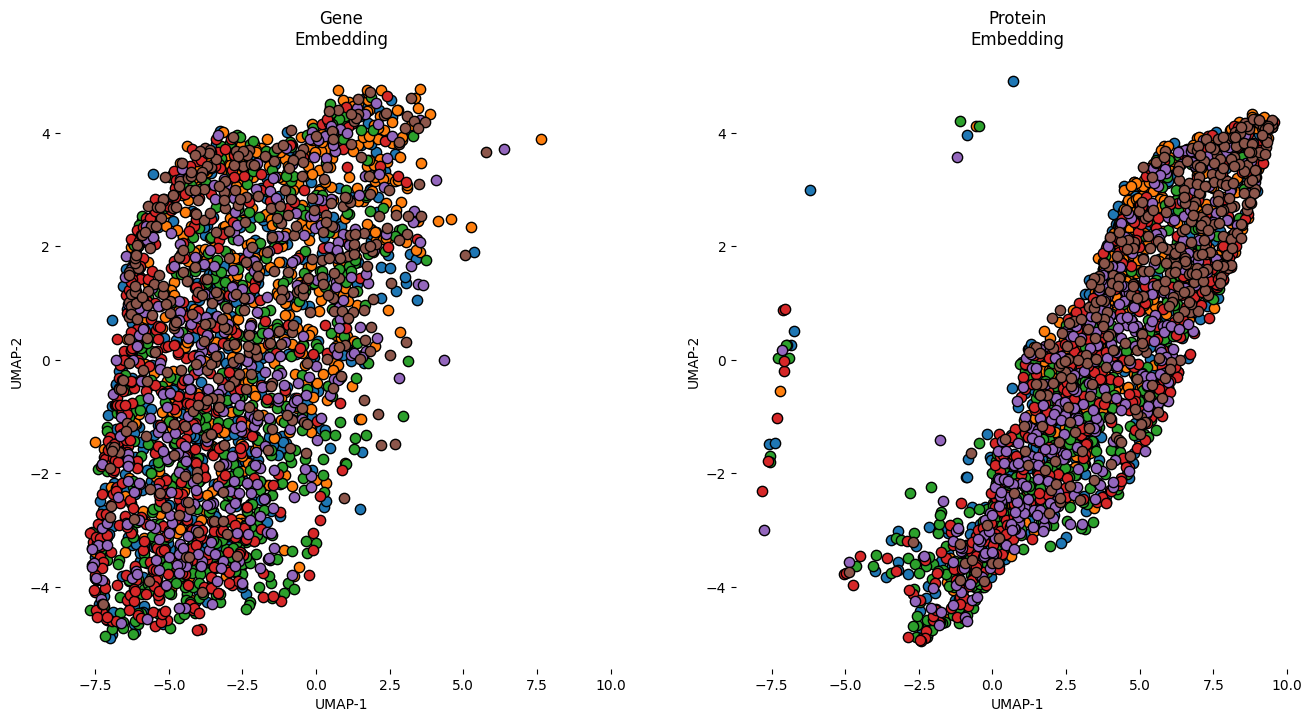

In [330]:
a, b = plot_latent([gex_z, pex_z], [type12, type22], 
            ['Gene\nEmbedding', 'Protein\nEmbedding'], 
            legend=False, method='umap',
            separate_dim=False);

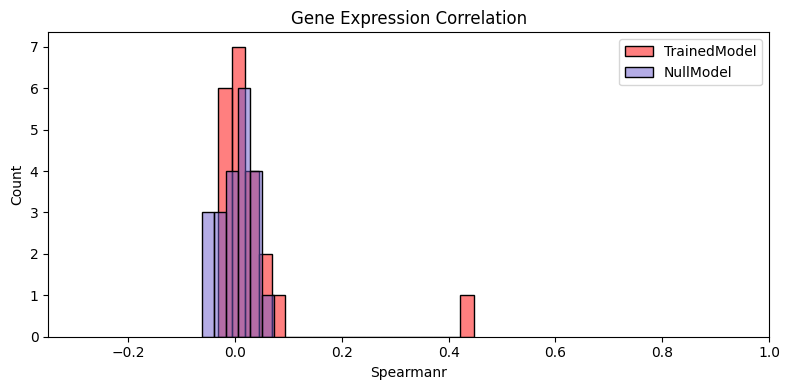

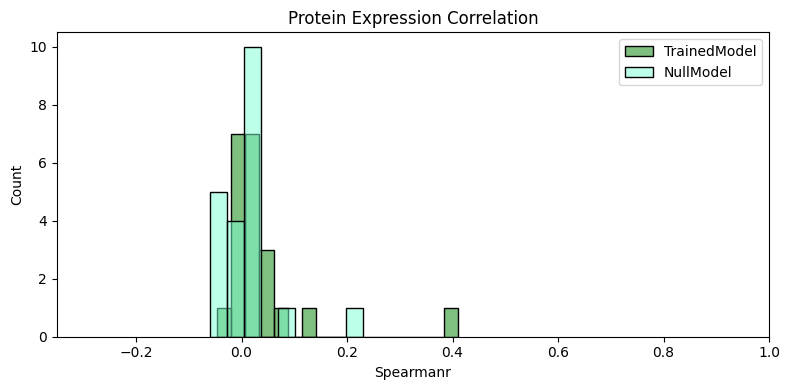

In [308]:
plt.rcParams['figure.figsize'] = (8, 4)
output = integrated_data
a = output.gex_recons.data.cpu().numpy()
b = d112.data.cpu().numpy()
c = output.pex_recons.data.cpu().numpy()
d = d122.data.cpu().numpy()

modelx = SpatialVAE([d112.shape[1], d122.shape[1]], 32).cuda()
modelx.eval()
outputx =  modelx(X=[d112, d122], A=gex2.adj_norm, corr=corr2)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

ax = outputx.gex_recons.data.cpu().numpy()
bx = d112.data.cpu().numpy()
cx = outputx.pex_recons.data.cpu().numpy()
dx = d122.data.cpu().numpy()

corrs = []
for ixs in range(b.shape[1]):
    corrs.append(spearmanr(b[:, ixs], a[:, ixs]).statistic)    
sns.histplot(corrs, color='red', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(bx.shape[1]):
    corrs.append(spearmanr(bx[:, ixs], ax[:, ixs]).statistic)    
sns.histplot(corrs, color='slateblue', alpha=0.5, label='NullModel')
plt.title('Gene Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

corrs = []
for ixs in range(d.shape[1]):
    corrs.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)    
sns.histplot(corrs, color='green', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(dx.shape[1]):
    corrs.append(spearmanr(dx[:, ixs], cx[:, ixs]).statistic)    
sns.histplot(corrs, color='aquamarine', alpha=0.5, label='NullModel')
plt.title('Protein Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class CTPNet(nn.Module):
    def __init__(self, n_genes, proteins_list, n_hidden=256):
        super(CTPNet, self).__init__()
        self.proteins = proteins_list
        self.fc1 = nn.Linear(n_genes, 512)
        self.fc2 = nn.Linear(512, n_hidden)

        self.fc3 = nn.ModuleDict({})

        for p in self.proteins:
            self.fc3[p] = nn.Linear(n_hidden, 64)
        
        self.fc4 = nn.ModuleDict({})
        
        for p in self.proteins:
            self.fc4[p] = nn.Linear(64, 1)
            
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        outputs={}
        
        for p in self.proteins:
            outputs[p] = self.fc4[p](F.relu(self.fc3[p](x)))
            
        return outputs
    
    
    def fit(self, X, y, epochs=200, lr=0.001, n_batches = 32):
        X_train = X
        y_train = y
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, amsgrad=True, weight_decay=0.001)
        max_epochs = epochs
        protein_list = list(self.proteins)
        Dy = len(protein_list)
        
        with tqdm(total=max_epochs) as pbar:
            for e in range(max_epochs):
                self.train()
                
                for i in range(int(y_train.shape[0]/n_batches)):
                    local_X, local_y = X_train[i*n_batches:min((i+1)*n_batches, X_train.shape[0]-1),], y_train[i*n_batches:min((i+1)*n_batches, y_train.shape[0]-1),]
                    optimizer.zero_grad() # zero the parameter gradients
                    outputs_dict = self.forward(local_X)
                    loss = None
                    loss_count = 0.0

                    for p in protein_list:
                        notNaN = (local_y[:,protein_list.index(p):(protein_list.index(p)+1)]==local_y[:,protein_list.index(p):(protein_list.index(p)+1)])
                        loss_p = criterion(outputs_dict[p][notNaN],local_y[:,protein_list.index(p):(protein_list.index(p)+1)][notNaN])

                        if not torch.isnan(loss_p):
                            loss_count += 1.0
                            if loss is None:
                                loss = loss_p
                            else:
                                loss = loss+loss_p

                    if loss is not None:
                        loss.backward()
                        optimizer.step()
                      
                with torch.no_grad():
                    self.eval()
                    outputs = self.forward(X)
                    preds = np.column_stack([outputs[p].data.cpu().numpy() for p in protein_list])
                    corrsx = []
                    c = preds
                    d = d12.cpu().numpy()
                    for ixs in range(d.shape[1]):
                        corrsx.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)
                        
                pbar.update()
                pbar.set_description(f'CORR: {np.mean(corrsx):.3f}')
                    
        with torch.no_grad():
            self.eval()
            outputs = self.forward(X)
            
            
            
        y_preds = np.column_stack([outputs[p].data.cpu().numpy() for p in protein_list])
        
        return y_preds

In [14]:
d11.shape, d12.shape

(torch.Size([2037, 196]), torch.Size([2037, 196]))

In [15]:
proteins = [i.replace('.', '-') for i in pdata.var_names]

In [19]:
ctpnet = CTPNet(n_genes=196, proteins_list=proteins).cuda()

In [20]:
preds = ctpnet.fit(X=d11, y=d12, epochs=100)

CORR: nan: 100%|██████████| 100/100 [15:03<00:00,  9.04s/it] 


In [21]:
preds

array([[-5.2254207e-02,  1.6057260e-01, -2.0555742e-01, ...,
        -2.0581991e-03, -1.6366780e-03, -2.4518301e-03],
       [-9.8410255e-01,  2.7630848e-01,  3.4177476e-01, ...,
        -2.0581991e-03, -1.6326106e-03, -2.4518305e-03],
       [-7.5801373e-01,  3.3478862e-01,  2.4427988e-02, ...,
        -2.0581991e-03, -1.6334666e-03, -2.4518303e-03],
       ...,
       [ 2.8397634e+00,  4.1141227e-01,  2.9921961e-01, ...,
        -2.0581991e-03, -1.6441098e-03, -2.4518308e-03],
       [ 3.0077205e+00,  8.8088268e-01,  5.2082223e-01, ...,
        -2.0581991e-03, -1.6441101e-03, -2.4518310e-03],
       [ 3.0555460e+00,  3.3396077e-01,  3.5790372e-01, ...,
        -2.0581991e-03, -1.6441101e-03, -2.4518308e-03]], dtype=float32)

In [22]:
corrsx = []
c = preds
d = d12.cpu().numpy()
for ixs in range(d.shape[1]):
    corrsx.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)

<AxesSubplot: ylabel='Count'>

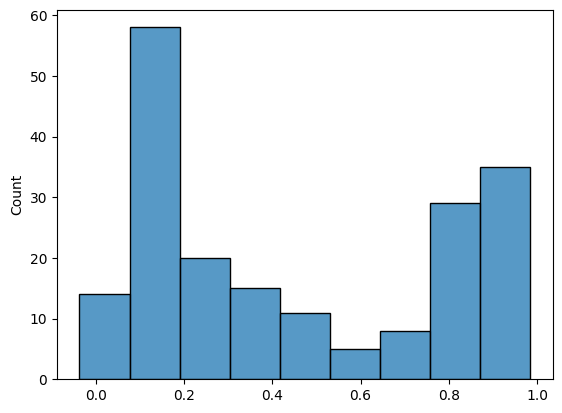

In [24]:
sns.histplot(corrsx)

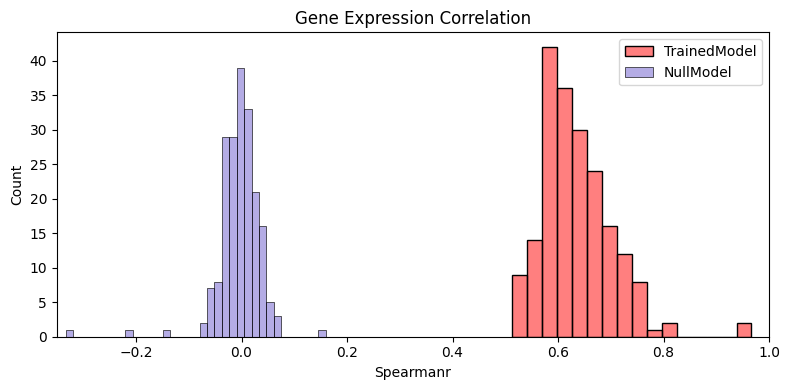

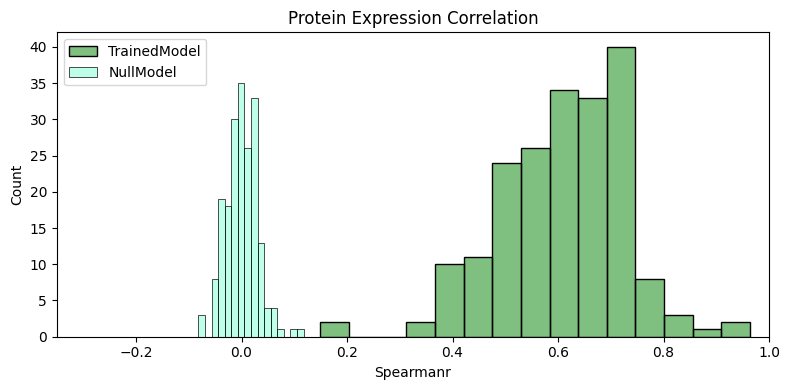

In [597]:
plt.rcParams['figure.figsize'] = (8, 4)
output = integrated_data
a = output.gex_recons.data.cpu().numpy()
b = d11.data.cpu().numpy()
c = output.pex_recons.data.cpu().numpy()
d = d12.data.cpu().numpy()

modelx = SpatialVAE([d11.shape[1], d12.shape[1]], 32).cuda()
modelx.eval()
outputx =  modelx(X=[d11, d12], A=gex.adj_norm, corr=corr)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

ax = outputx.gex_recons.data.cpu().numpy()
bx = d11.data.cpu().numpy()
cx = outputx.pex_recons.data.cpu().numpy()
dx = d12.data.cpu().numpy()

corrs = []
for ixs in range(b.shape[1]):
    corrs.append(spearmanr(b[:, ixs], a[:, ixs]).statistic)    
sns.histplot(corrs, color='red', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(bx.shape[1]):
    corrs.append(spearmanr(bx[:, ixs], ax[:, ixs]).statistic)    
sns.histplot(corrs, color='slateblue', alpha=0.5, label='NullModel')
plt.title('Gene Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

corrs = []
for ixs in range(d.shape[1]):
    corrs.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)    
sns.histplot(corrs, color='green', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(dx.shape[1]):
    corrs.append(spearmanr(dx[:, ixs], cx[:, ixs]).statistic)    
sns.histplot(corrs, color='aquamarine', alpha=0.5, label='NullModel')
plt.title('Protein Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

In [81]:
clustering = LeidenClustering()

In [88]:
latent_gex = AnnData(gex_z)
latent_gex.obsm['spatial'] = adata.obsm['spatial']
latent_gex.uns['spatial'] = adata.uns['spatial']
sc.tl.pca(latent_gex)
sc.pp.neighbors(latent_gex)

clustering.fit(gex_z)

adata.obs['spicess'] = clustering.labels_
adata.obs['spicess'] = adata.obs['spicess'].astype('category')
pdata.obsm['spatial'] = adata.obsm['spatial']

sc.tl.pca(adata)
sc.pp.neighbors(adata)

sc.tl.pca(pdata)
sc.pp.neighbors(pdata)

resolution = 0.5
size = 2
linewidth = 0.2
img = True
alpha = 1

sc.tl.leiden(pdata, resolution=resolution)
sc.tl.leiden(latent_gex, resolution=resolution)
sc.tl.leiden(adata, resolution=resolution)

pdata.uns['spatial'] = adata.uns['spatial']
pdata.obs['spicess'] = clustering.labels_
pdata.obs['spicess'] = pdata.obs['spicess'].astype('category')

f, axs = plt.subplots(1, 3, figsize=(15, 15), dpi=180)

sq.pl.spatial_scatter(latent_gex, color=['leiden'], size=size, linewidth=linewidth, edgecolor='black', frameon=False, ax=axs[2], title='Protein+mRNA', palette='Dark2', alpha=alpha, img=img)
sq.pl.spatial_scatter(pdata, color=['leiden'], size=size, edgecolor='black', linewidth=linewidth, frameon=False, ax=axs[1], title='Protein', alpha=alpha, img=img)
sq.pl.spatial_scatter(adata, color=['leiden'], size=size, edgecolor='black', linewidth=linewidth, frameon=False, ax=axs[0], title='mRNA', alpha=alpha, palette='Accent', img=img)
# sq.pl.spatial_scatter(adata, color=None, size=0, frameon=False, ax=axs[-1], title='Tissue', img=True)


axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()

# plt.savefig('clusters.png', format='png', dpi=200)
plt.show()

KeyboardInterrupt: 

In [202]:
# plt.rcParams['figure.figsize'] = (5, 5)
# ix = 99
# sns.scatterplot(b[:, ix], a[:, ix], color='limegreen')
# plt.title(f'Gene: {adata.var_names[ix]}\nCORR: {spearmanr(b[:, ix], a[:, ix]).statistic:.3f}')
# plt.savefig('protein.svg', dpi=120, format='svg')
# plt.show()

In [539]:
modelx = SpatialVAE([d11.shape[1], d12.shape[1]], 32).cuda()
modelx.eval()
outputx =  modelx(X=[d11, d12], A=gex.adj_norm, corr=corr)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

ax = outputx.gex_recons.data.cpu().numpy()
bx = gex.features_pca.data.cpu().numpy()
cx = outputx.pex_recons.data.cpu().numpy()
dx = pex.features_pca.data.cpu().numpy()

In [540]:
corrs = []
for ixs in range(b.shape[1]):
    corrs.append(spearmanr(b[:, ixs], a[:, ixs]).statistic)    
sns.histplot(corrs, color='red', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(bx.shape[1]):
    corrs.append(spearmanr(bx[:, ixs], ax[:, ixs]).statistic)    
sns.histplot(corrs, color='blue', alpha=0.5, label='NullModel')
plt.title('Gene Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.tight_layout()
plt.legend()
plt.savefig('perf_gex.svg', format='svg', dpi=300)
plt.show()

corrs = []
for ixs in range(d.shape[1]):
    corrs.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)    
sns.histplot(corrs, color='red', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(dx.shape[1]):
    corrs.append(spearmanr(dx[:, ixs], cx[:, ixs]).statistic)    
sns.histplot(corrs, color='blue', alpha=0.5, label='NullModel')
plt.title('Protein Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.tight_layout()
plt.legend()
plt.savefig('perf_pex.svg', format='svg', dpi=300)
plt.show()

IndexError: index 196 is out of bounds for axis 1 with size 196